🔬 Why Graphs for Materials?

In materials science, we want to understand how atoms arrange themselves and how those arrangements give rise to properties like:

electrical conductivity,

magnetism,

chemical stability.

Traditional machine learning approaches flatten atomic data into long vectors, which lose the spatial relationships between atoms.
By contrast, Graph Neural Networks (GNNs) naturally preserve geometry and composition:

atoms → nodes,

bonds or neighbor relationships → edges.

This makes them powerful tools for predicting material properties.

Graph Neural Networks let us model materials directly from atomic structures, without hand-crafted features. They:

respect the geometry and chemistry of materials,

enable property prediction from first principles,

but require careful design to avoid oversmoothing.

### Crystal → Graph

Input: a CIF file (e.g., BiFeO3.cif).

Process:

Use pymatgen and ASE to parse structure.

Each atom → node (with attributes like element type).

Neighbors within 4 Å → edges (with distance as a possible feature).

Output: a graph drawn with NetworkX, showing Bi (orange), Fe (red), O (blue).
→ This graph is the same format a GNN (like CGCNN) will use for learning.

In [ ]:
# --- Install (run once per environment) ---
# If you're in Colab/Jupyter, uncomment:
# !pip install --upgrade ase pymatgen networkx matplotlib numpy torch

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from pymatgen.io.cif import CifParser
from pymatgen.io.ase import AseAtomsAdaptor
from ase.neighborlist import neighbor_list

🔎 What is an ASE object?

ASE stands for the Atomic Simulation Environment — it’s a Python library widely used in materials science and computational chemistry.

The ASE object you saw (atoms = AseAtomsAdaptor.get_atoms(structure)) is an instance of the class ase.Atoms.

🧱 The ase.Atoms object

This is the core data structure of ASE. It represents a collection of atoms and contains:

Atomic positions in Cartesian coordinates (x, y, z).

Chemical species (H, O, Fe, etc.).

Cell information (the simulation box or crystal lattice).

Periodic boundary conditions (PBCs).

Optional: atomic charges, magnetic moments, velocities, etc.

Think of it as a container that fully describes a material structure in 3D space.


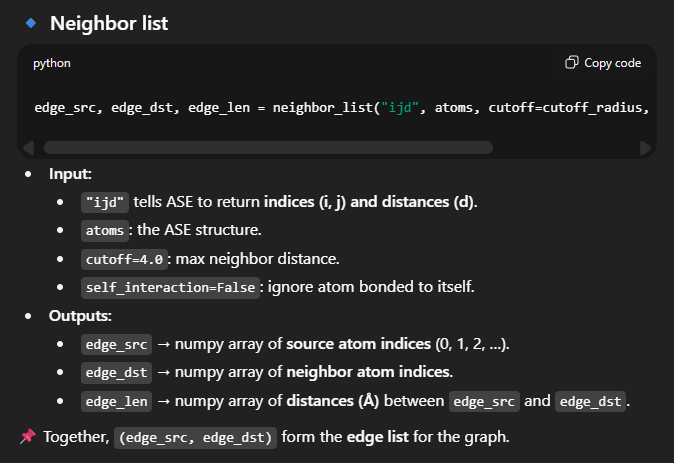

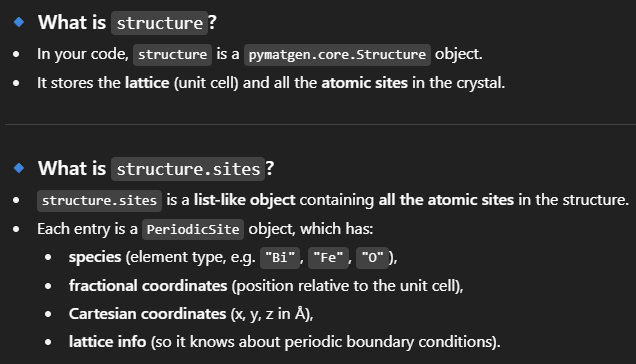

[PeriodicSite: FE2 (Fe) (-5.053, -3.556, -8.044) [0.7789, 0.7789, 0.6633], PeriodicSite: FE2 (Fe) (-1.81, -1.273, -2.462) [0.2789, 0.2789, 0.1633], PeriodicSite: BI1 (Bi) (0.0, 0.0, 0.0) [0.0, 0.0, 0.0], PeriodicSite: BI1 (Bi) (-3.244, -2.283, -5.582) [0.5, 0.5, 0.5], PeriodicSite: O3 (O) (-1.096, -2.174, -6.327) [0.4762, 0.06511, 0.857], PeriodicSite: O3 (O) (-3.295, -2.747, -7.81) [0.6017, 0.4762, 0.857], PeriodicSite: O3 (O) (-3.025, -0.2972, -6.674) [0.06511, 0.6017, 0.857], PeriodicSite: O3 (O) (-2.907, -0.4643, -3.855) [0.1017, 0.5651, 0.357], PeriodicSite: O3 (O) (-2.092, -4.456, -4.991) [0.9762, 0.1017, 0.357], PeriodicSite: O3 (O) (-5.66, -2.58, -6.272) [0.5651, 0.9762, 0.357]]
Fe
[0.77891 0.77891 0.66327]
[-5.05338652 -3.55579734 -8.04417653]


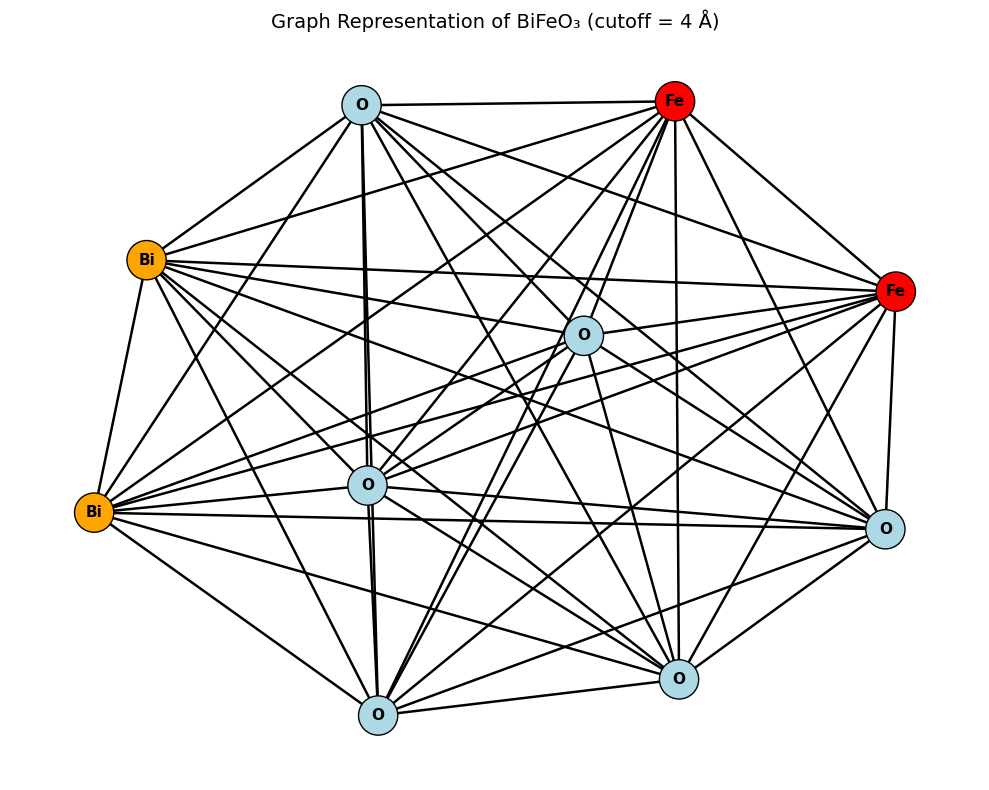

In [ ]:
# ---------- Helper: safe conversion preserving ASE PBC ----------
##In crystalline materials, atoms repeat periodically in 3D space.
##CIF files store this lattice periodicity.
##When converting pymatgen.Structure → ase.Atoms, sometimes ASE does not automatically set the PBCs correctly, or you may want to force custom PBC settings (like periodic only in x and y, not z).
def pmg_to_ase_with_pbc(structure, force_pbc=None):
    """
    Convert pymatgen Structure -> ASE Atoms.
    Optionally force a specific per-axis PBC on the ASE Atoms.
    """
    atoms = AseAtomsAdaptor.get_atoms(structure)
    if force_pbc is not None:
        atoms.set_pbc(force_pbc)
    return atoms


# ---------- Load structure (modern API) ----------
parser = CifParser("/content/BiFeO3.cif")
# New method (replaces deprecated get_structures)
structure = parser.parse_structures(primitive=True)[0]
# print("Structure loaded:", structure.composition.reduced_formula)

# ---------- Convert to ASE and (optionally) enforce PBC ----------
# For BiFeO3 (a bulk crystal), full periodicity is expected.
# If you *want* partial PBC for a special test, set force_pbc=(True, True, False).
atoms = pmg_to_ase_with_pbc(structure, force_pbc=None)
# print("ASE PBC observed:", atoms.get_pbc())
# print(atoms.get_chemical_formula(),atoms.get_cell())

# # ---------- Neighbor list ----------
cutoff_radius = 4.0  # Å
edge_src, edge_dst, edge_len = neighbor_list("ijd", atoms, cutoff=cutoff_radius, self_interaction=False)
#which atom index is connected to which neighbor, and at what distance.

# Print the first 20 neighbor pairs
# for s, d, l in zip(edge_src[:20], edge_dst[:20], edge_len[:20]):
#     print(f"Atom {s} --> Atom {d}, distance = {l:.2f} Å")


# # ---------- Build graph ----------
color_map = {"Bi": "orange", "Fe": "red", "O": "lightblue"}
G = nx.Graph()

print(structure.sites)
site0 = structure.sites[0]
print(site0.species_string)   # "Bi"
print(site0.frac_coords)      # fractional coordinates (0, 0, 0)
print(site0.coords)           # cartesian coordinates (x,y,z in Å)

for i, site in enumerate(structure.sites):
    G.add_node(i, element=site.species_string)

for i, j, d in zip(edge_src, edge_dst, edge_len):
    G.add_edge(int(i), int(j), length=float(d))

labels = {i: G.nodes[i]["element"] for i in G.nodes}
colors = [color_map[G.nodes[i]["element"]] for i in G.nodes]

# # ---------- Plot ----------
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(10, 8), facecolor="white")
nx.draw_networkx_nodes(G, pos, node_color=colors, edgecolors="black", node_size=800)
nx.draw_networkx_edges(G, pos, width=1.8)
nx.draw_networkx_labels(G, pos, labels, font_size=11, font_weight="bold")
plt.title("Graph Representation of BiFeO₃ (cutoff = 4 Å)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()
